In [ ]:
# Install required libraries
!pip install pydub

import os
from pydub import AudioSegment
import math
from google.colab import drive
import shutil

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install required libraries
!pip install librosa matplotlib pandas numpy scikit-learn tensorflow plotly pydub

import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from google.colab import drive
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

# Mount Google Drive
drive.mount('/content/drive')

# Verify GPU
print("GPUs available:", len(tf.config.list_physical_devices('GPU')))
!nvidia-smi

# Paths and raagas
data_dir = '/content/drive/MyDrive/ML_RAAGA_Analysis'
raagas = ['Shankarabharanam', 'Revathi', 'Abheri', 'Brindavanasaranga', 'Mayamalavagowla']

# GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print("Enabled GPU memory growth")

# Silence detection
def is_silent(path, thresh=0.01):
    y, sr = librosa.load(path, sr=None)
    rms = librosa.feature.rms(y=y)[0]
    return np.mean(rms) < thresh

# Feature extraction
def extract_features(path):
    y, sr = librosa.load(path, sr=22050)
    y, _ = librosa.effects.trim(y, top_db=30)
    y = y[:30*sr]
    n_fft, hop = 1024, 512
    chroma = librosa.feature.chroma_stft(y,y, sr=sr, n_fft=n_fft, hop_length=hop)
    chroma_cens = librosa.feature.chroma_cens(y,y, sr=sr, hop_length=hop)
    tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20, n_fft=n_fft, hop_length=hop)
    spec_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, n_fft=n_fft, hop_length=hop)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=n_fft, hop_length=hop)
    spec_roll = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=n_fft, hop_length=hop)
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft, hop_length=hop)
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr, hop_length=hop)
    zcr = librosa.feature.zero_crossing_rate(y, hop_length=hop)
    pitches, _ = librosa.piptrack(y=y, sr=sr, n_fft=n_fft, hop_length=hop)
    pv = pitches[pitches>0]
    pm, ps = (pv.mean() if pv.size else 0, pv.std() if pv.size else 0)
    if pv.size:
        cents = 1200*np.log2(pv/librosa.note_to_hz('C'))
        hist,_ = np.histogram(cents%1200, bins=12, range=(0,1200))
        ph = hist/hist.sum()
    else:
        ph = np.zeros(12)
    feats = {
        'chroma_mean': chroma.mean(axis=1), 'chroma_std': chroma.std(axis=1),
        'chroma_cens_mean': chroma_cens.mean(axis=1), 'chroma_cens_std': chroma_cens.std(axis=1),
        'tonnetz_mean': tonnetz.mean(axis=1), 'tonnetz_std': tonnetz.std(axis=1),
        'mfcc_mean': mfcc.mean(axis=1), 'mfcc_std': mfcc.std(axis=1),
        'contrast_mean': spec_contrast.mean(axis=1), 'contrast_std': spec_contrast.std(axis=1),
        'bandwidth_mean': spec_bw.mean(), 'bandwidth_std': spec_bw.std(),
        'rolloff_mean': spec_roll.mean(), 'rolloff_std': spec_roll.std(),
        'centroid_mean': spec_cent.mean(), 'centroid_std': spec_cent.std(),
        'tempo': tempo, 'zcr_mean': zcr.mean(), 'zcr_std': zcr.std(),
        'pitch_mean': pm, 'pitch_std': ps, 'pitch_hist': ph
    }
    return feats

# Build dataset
def collect_dataset(thresh=0.01):
    data, labels = [], []
    for r in raagas:
        folder = os.path.join(data_dir, r)
        for f in os.listdir(folder):
            if f.lower().endswith(('.mp3','.wav')):
                p = os.path.join(folder, f)
                if is_silent(p, thresh): continue
                feats = extract_features(p)
                flat = []
                for k,v in feats.items():
                    flat.extend(v if isinstance(v,np.ndarray) else [v])
                data.append(flat)
                labels.append(r)
    cols = [f'f{i}' for i in range(len(data[0]))]
    df = pd.DataFrame(data, columns=cols)
    df['raaga'] = labels
    return df

# Train/Test split and classifier
def train_model(df):
    X = df.drop('raaga', axis=1)
    y = LabelEncoder().fit_transform(df['raaga'])
    y_cat = to_categorical(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2,
                                                      stratify=y, random_state=42)
    scaler = StandardScaler().fit(X_train)
    X_train_s, X_test_s = scaler.transform(X_train), scaler.transform(X_test)
    tf.keras.mixed_precision.set_global_policy('mixed_float16')
    model = Sequential([
        Dense(256, activation='relu', input_shape=(X_train_s.shape[1],)), Dropout(0.4),
        Dense(128, activation='relu'), Dropout(0.3),
        Dense(64, activation='relu'), Dropout(0.2),
        Dense(y_cat.shape[1], activation='softmax', dtype='float32')
    ])
    model.compile('adam', 'categorical_crossentropy', ['accuracy'])
    model.fit(X_train_s, y_train, epochs=12, batch_size=32,
              validation_split=0.2, callbacks=[
                  tf.keras.callbacks.EarlyStopping('val_loss', patience=5, restore_best_weights=True)
              ])
    print(classification_report(y_test.argmax(axis=1),
                                model.predict(X_test_s).argmax(axis=1),
                                target_names=LabelEncoder().fit(df['raaga']).classes_))
    return model, scaler, LabelEncoder().fit(df['raaga'])

# Classify single clip
def classify_clip(path, model, scaler, le):
    feats = extract_features(path)
    flat = []
    for k,v in feats.items(): flat.extend(v if isinstance(v,np.ndarray) else [v])
    Xs = scaler.transform([flat])
    pred = model.predict(Xs)[0]
    idx = pred.argmax()
    return le.inverse_transform([idx])[0], pred[idx]

# -- Execution --
df = collect_dataset()
print("Dataset samples:", len(df))
model, scaler, le = train_model(df)

# Example: classify a random clip
random_clip = '/content/drive/MyDrive/ML_RAAGA_Analysis/Abheri/Bhajare Re Manasa - Ragam Abheri - Mysore Vasudevachar Krithi [ebFAOkuXJB8]_segment_002.mp3'  # update filename
raaga, conf = classify_clip(random_clip, model, scaler, le)
print(f"Predicted: {raaga} with confidence {conf:.2%}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
GPUs available: 1
Sun May 11 18:41:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Def

TypeError: chroma_stft() takes 0 positional arguments but 2 positional arguments (and 3 keyword-only arguments) were given

Checking GPU availability...
Num GPUs Available: 1
Wed Oct 22 18:55:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A

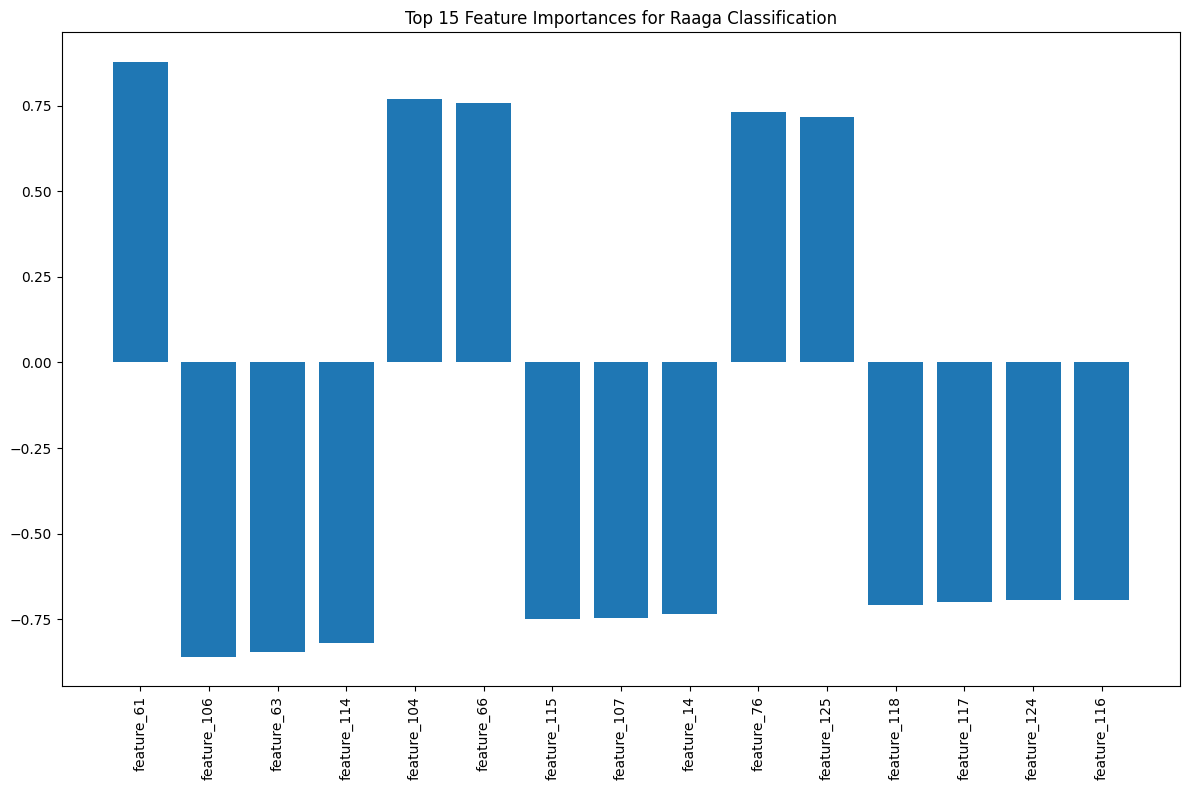

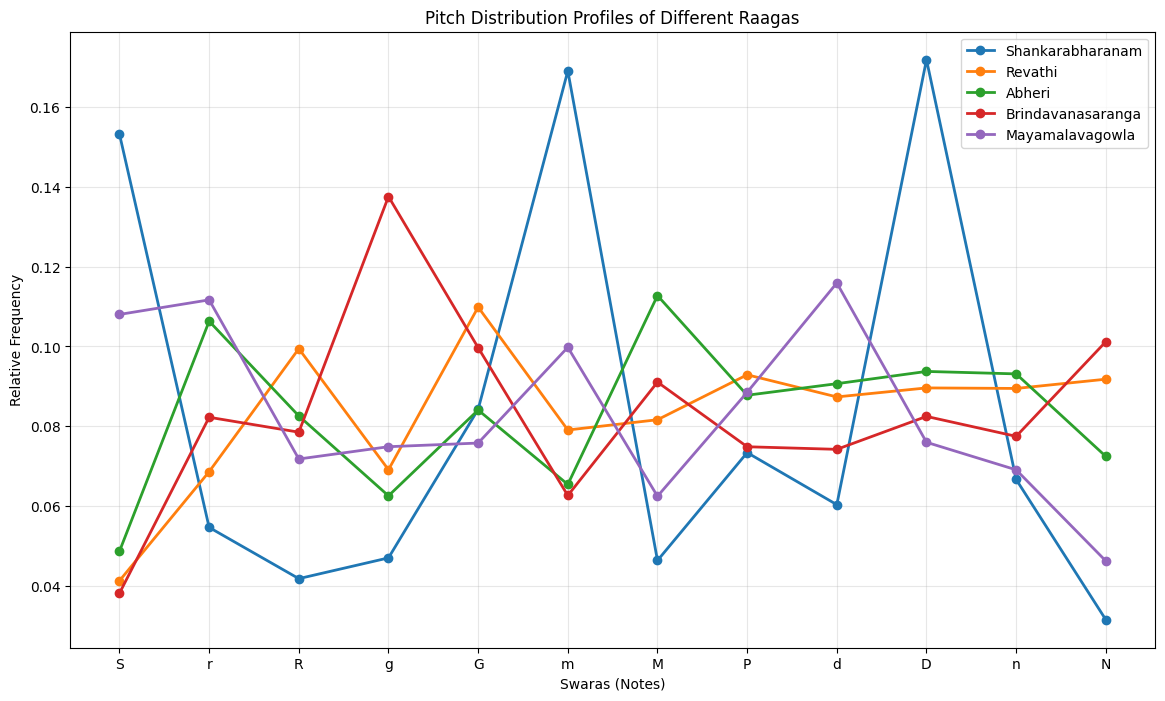


Building and training raaga classifier with T4 GPU acceleration...

Class Distribution:
Shankarabharanam: 158 samples
Brindavanasaranga: 138 samples
Mayamalavagowla: 120 samples
Abheri: 114 samples
Revathi: 108 samples
Compute dtype: float16
Variable dtype: float32
Epoch 1/12
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 335ms/step - accuracy: 0.3103 - loss: 1.5659 - val_accuracy: 0.7647 - val_loss: 0.8848 - learning_rate: 0.0010
Epoch 2/12
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7547 - loss: 0.8277 - val_accuracy: 0.8333 - val_loss: 0.5340 - learning_rate: 0.0010
Epoch 3/12
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8180 - loss: 0.4813 - val_accuracy: 0.8922 - val_loss: 0.2993 - learning_rate: 0.0010
Epoch 4/12
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8722 - loss: 0.3843 - val_accuracy: 0.9902 - val_loss: 0.1335 - learning_rate: 0.0010
Epoch 5/12
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9510 - loss: 0.1747 - val_accuracy: 0.9902 - val_loss: 0.0629 - l

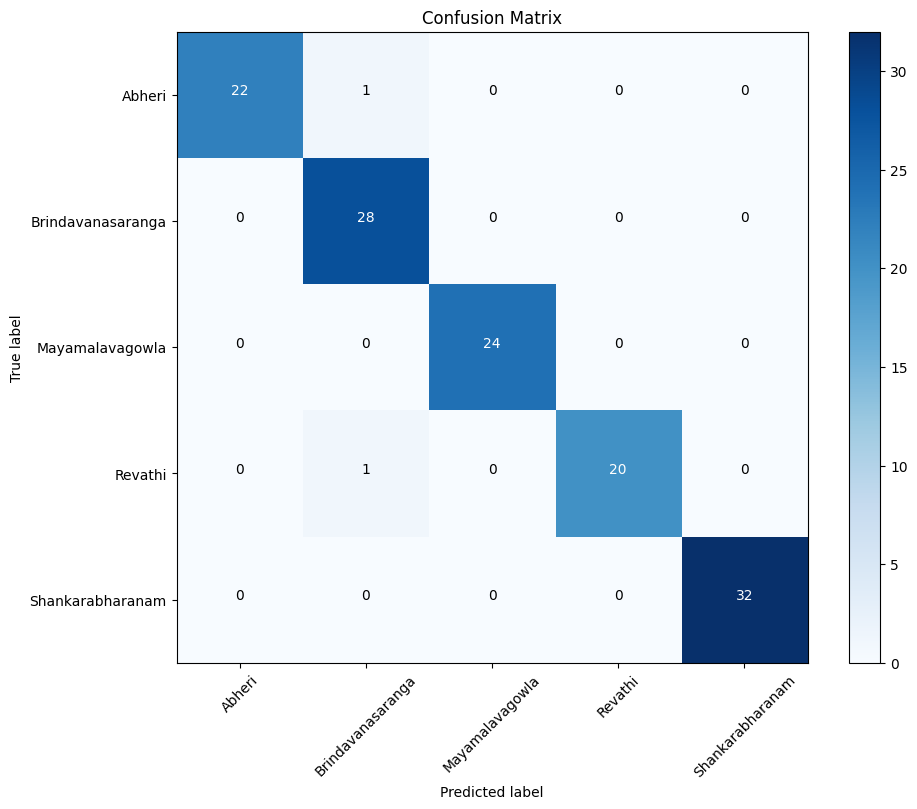

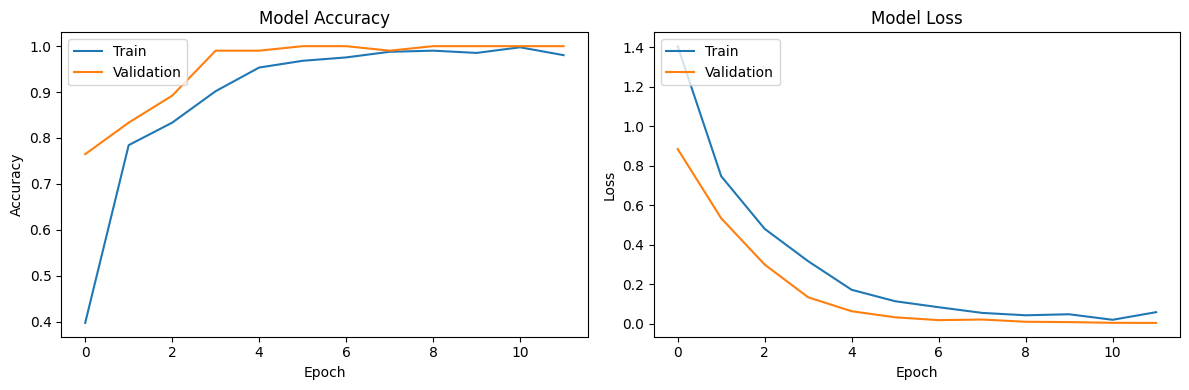

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=/content/raaga_model.

In [ ]:
# Install required libraries
!pip install librosa matplotlib pandas numpy scikit-learn tensorflow plotly pydub

import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from google.colab import drive
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

# First, verify we're using the T4 GPU
print("Checking GPU availability...")
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
!nvidia-smi

# Define the path to the folder containing raaga samples
# Each raaga should have its own subfolder
DATASET_PATH = '/content/drive/MyDrive/ML_RAAGA_Analysis'  # Update this path

# List of raagas to analyze (these should match your folder names)
raagas = ['Shankarabharanam', 'Revathi', 'Abheri', 'Brindavanasaranga', 'Mayamalavagowla']

# Set memory growth to avoid OOM errors on T4 GPU
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("Memory growth enabled for GPU")

def is_silent(audio_path, silence_threshold=0.01):
    """
    Detect if an audio clip is silent or has no significant sound.

    Args:
        audio_path: Path to the audio file
        silence_threshold: RMS threshold below which audio is considered silent

    Returns:
        Boolean indicating if the audio is silent
    """
    try:
        y, sr = librosa.load(audio_path, sr=None)
        # Calculate RMS energy
        rms = librosa.feature.rms(y=y)[0]
        # If the mean RMS is below threshold, consider it silent
        return np.mean(rms) < silence_threshold
    except Exception as e:
        print(f"Error processing {audio_path}: {str(e)}")
        return True  # Treat error files as silent

def extract_features(file_path):
    """
    Extract features from an audio file for raaga analysis

    Args:
        file_path: Path to the audio file

    Returns:
        Dictionary of features, audio signal, and sample rate
    """
    try:
        # Load audio file
        y, sr = librosa.load(file_path, sr=22050)

        # Trim silence
        y, _ = librosa.effects.trim(y, top_db=30)

        # Set duration to 30 seconds (or use the entire file if shorter)
        duration = 30 * sr
        if len(y) > duration:
            y = y[:duration]

        # Extract features - optimized for T4 GPU
        # Use smaller frame sizes for faster processing
        n_fft = 1024  # Smaller FFT window
        hop_length = 512  # Smaller hop length

        # 1. Tonal features - important for raaga identification
        chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
        chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr, hop_length=hop_length)
        tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)

        # 2. Spectral features - capture timbre
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20, n_fft=n_fft, hop_length=hop_length)
        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)

        # 3. Rhythm features
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr, hop_length=hop_length)
        zcr = librosa.feature.zero_crossing_rate(y, hop_length=hop_length)

        # 4. Pitch features - critical for raaga identification
        # Use a smaller hop length for faster processing
        pitches, magnitudes = librosa.piptrack(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
        pitch_mean = np.mean(pitches[pitches > 0]) if np.any(pitches > 0) else 0
        pitch_std = np.std(pitches[pitches > 0]) if np.any(pitches > 0) else 0

        # Calculate pitch histogram (important for raaga identification)
        if np.any(pitches > 0):
            valid_pitches = pitches[pitches > 0]
            cents = 1200 * np.log2(valid_pitches / librosa.note_to_hz('C'))
            cents_folded = cents % 1200
            pitch_hist = np.histogram(cents_folded, bins=12, range=(0, 1200))[0]
            pitch_hist = pitch_hist / np.sum(pitch_hist) if np.sum(pitch_hist) > 0 else pitch_hist
        else:
            pitch_hist = np.zeros(12)

        # Calculate statistics for each feature
        features = {
            # Tonal features
            'chroma_mean': np.mean(chroma, axis=1),
            'chroma_std': np.std(chroma, axis=1),
            'chroma_cens_mean': np.mean(chroma_cens, axis=1),
            'chroma_cens_std': np.std(chroma_cens, axis=1),
            'tonnetz_mean': np.mean(tonnetz, axis=1),
            'tonnetz_std': np.std(tonnetz, axis=1),

            # Spectral features
            'mfcc_mean': np.mean(mfcc, axis=1),
            'mfcc_std': np.std(mfcc, axis=1),
            'contrast_mean': np.mean(spectral_contrast, axis=1),
            'contrast_std': np.std(spectral_contrast, axis=1),
            'bandwidth_mean': np.mean(spectral_bandwidth),
            'bandwidth_std': np.std(spectral_bandwidth),
            'rolloff_mean': np.mean(spectral_rolloff),
            'rolloff_std': np.std(spectral_rolloff),
            'centroid_mean': np.mean(spectral_centroid),
            'centroid_std': np.std(spectral_centroid),

            # Rhythm features
            'tempo': tempo,
            'zcr_mean': np.mean(zcr),
            'zcr_std': np.std(zcr),

            # Pitch features
            'pitch_mean': pitch_mean,
            'pitch_std': pitch_std,
            'pitch_hist': pitch_hist
        }

        return features, y, sr

    except Exception as e:
        print(f"Error extracting features from {file_path}: {str(e)}")
        return None, None, None

def collect_dataset(silence_threshold=0.01):
    """
    Collect features from all raaga samples and create a dataset,
    filtering out silent clips.

    Args:
        silence_threshold: RMS threshold below which audio is considered silent

    Returns:
        DataFrame with features and labels
    """
    features_list = []
    labels = []
    audio_files = []
    silent_count = 0
    music_count = 0

    for raaga in raagas:
        raaga_path = os.path.join(DATASET_PATH, raaga)

        if not os.path.exists(raaga_path):
            print(f"Path not found: {raaga_path}")
            continue

        print(f"Processing {raaga} samples...")
        raaga_file_count = 0

        for file_name in os.listdir(raaga_path):
            if file_name.endswith(('.mp3', '.wav')):
                file_path = os.path.join(raaga_path, file_name)

                # Check if the file is silent
                if is_silent(file_path, silence_threshold):
                    print(f"  Skipping silent file: {file_name}")
                    silent_count += 1
                    continue

                # Extract features for non-silent files
                features, _, _ = extract_features(file_path)

                if features:
                    # Flatten all feature arrays and concatenate
                    flat_features = []
                    for feature_name, feature_value in features.items():
                        if feature_name != 'pitch_hist':  # Handle pitch histogram separately
                            if isinstance(feature_value, np.ndarray):
                                flat_features.extend(feature_value)
                            else:
                                flat_features.append(feature_value)

                    # Add pitch histogram
                    flat_features.extend(features['pitch_hist'])

                    features_list.append(flat_features)
                    labels.append(raaga)
                    audio_files.append(file_path)
                    music_count += 1
                    raaga_file_count += 1

        print(f"  Found {raaga_file_count} valid music files for {raaga}")

    print(f"Found {silent_count} silent files (skipped) and {music_count} music files (processed)")

    # Convert to DataFrame
    if not features_list:
        print("No valid audio files found!")
        return None

    feature_names = []
    feature_count = len(features_list[0])
    for i in range(feature_count):
        feature_names.append(f'feature_{i}')

    df = pd.DataFrame(features_list, columns=feature_names)
    df['raaga'] = labels
    df['file_path'] = audio_files

    return df

def visualize_raaga_features(df):
    """
    Visualize key features of different raagas

    Args:
        df: DataFrame with features and labels
    """
    if df is None or len(df) == 0:
        print("No data to visualize!")
        return

    # PCA for dimensionality reduction and visualization
    from sklearn.decomposition import PCA

    # Select only numeric columns for PCA
    numeric_cols = df.select_dtypes(include=np.number).columns
    X = df[numeric_cols]

    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply PCA
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(X_scaled)

    # Create a DataFrame with PCA results
    pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2', 'PC3'])
    pca_df['raaga'] = df['raaga']

    # Plot 3D scatter plot
    fig = px.scatter_3d(pca_df, x='PC1', y='PC2', z='PC3', color='raaga',
                        title='Raaga Clusters in 3D PCA Space',
                        labels={'PC1': 'Principal Component 1',
                                'PC2': 'Principal Component 2',
                                'PC3': 'Principal Component 3'})
    fig.update_layout(legend_title_text='Raaga')
    fig.show()

    # Create a feature importance plot based on PCA loadings
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    loading_matrix = pd.DataFrame(loadings, columns=['PC1', 'PC2', 'PC3'], index=numeric_cols)
    loading_matrix['abs_pc1'] = abs(loading_matrix['PC1'])
    sorted_loadings = loading_matrix.sort_values('abs_pc1', ascending=False).head(15)

    plt.figure(figsize=(12, 8))
    plt.bar(sorted_loadings.index, sorted_loadings['PC1'])
    plt.xticks(rotation=90)
    plt.title('Top 15 Feature Importances for Raaga Classification')
    plt.tight_layout()
    plt.show()

    # Visualize pitch histograms for each raaga
    # This helps identify the key notes (swaras) that characterize each raaga
    pitch_cols = [col for col in numeric_cols if 'feature_' in col][-12:]  # Last 12 features are pitch histogram
    pitch_data = df[pitch_cols + ['raaga']]

    # Calculate average pitch histogram for each raaga
    raaga_pitch_profiles = pitch_data.groupby('raaga').mean()

    # Swara names for x-axis
    swara_names = ['S', 'r', 'R', 'g', 'G', 'm', 'M', 'P', 'd', 'D', 'n', 'N']

    # Plot pitch profiles
    plt.figure(figsize=(14, 8))
    for raaga in raagas:
        if raaga in raaga_pitch_profiles.index:
            plt.plot(swara_names, raaga_pitch_profiles.loc[raaga], label=raaga, linewidth=2, marker='o')

    plt.title('Pitch Distribution Profiles of Different Raagas')
    plt.xlabel('Swaras (Notes)')
    plt.ylabel('Relative Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def build_raaga_classifier(df):
    """
    Build and train a neural network to classify raagas - optimized for T4 GPU

    Args:
        df: DataFrame with features and labels

    Returns:
        Trained model, scaler, and label encoder
    """
    if df is None or len(df) == 0:
        print("No data to build classifier!")
        return None, None, None

    # Prepare data
    X = df.drop(['raaga', 'file_path'], axis=1)
    y = df['raaga']

    # Check class distribution
    class_distribution = y.value_counts()
    print("\nClass Distribution:")
    for raaga, count in class_distribution.items():
        print(f"{raaga}: {count} samples")

    # Encode labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    y_categorical = to_categorical(y_encoded)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42, stratify=y_encoded)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Configure TensorFlow for T4 GPU optimization
    # Mixed precision training for faster computation on T4 GPU
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
    print('Compute dtype:', policy.compute_dtype)
    print('Variable dtype:', policy.variable_dtype)

    # Build model - optimized for T4 GPU
    model = Sequential([
        Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.4),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(y_categorical.shape[1], activation='softmax', dtype='float32')  # Final layer must be float32
    ])

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train model with GPU-optimized batch size
    # T4 GPU performs well with batch sizes between 32-64
    history = model.fit(
        X_train_scaled, y_train,
        epochs=12,
        batch_size=32,  # Optimized for T4 GPU
        validation_split=0.2,
        verbose=1,
        callbacks=[
            # Early stopping to prevent overfitting
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=15,
                restore_best_weights=True
            ),
            # Reduce learning rate when training plateaus
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=0.00001
            )
        ]
    )

    # Evaluate model
    y_pred_prob = model.predict(X_test_scaled)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_test_decoded = np.argmax(y_test, axis=1)

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test_decoded, y_pred, target_names=le.classes_))

    # Plot confusion matrix
    cm = confusion_matrix(y_test_decoded, y_pred)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(le.classes_))
    plt.xticks(tick_marks, le.classes_, rotation=45)
    plt.yticks(tick_marks, le.classes_)

    # Add text annotations to confusion matrix
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.show()

    return model, scaler, le

def classify_new_audio(audio_path, model, scaler, label_encoder, silence_threshold=0.01):
    """
    Classify a new audio file into one of the raagas

    Args:
        audio_path: Path to the audio file
        model: Trained model
        scaler: Fitted scaler
        label_encoder: Fitted label encoder
        silence_threshold: RMS threshold below which audio is considered silent

    Returns:
        Predicted raaga and confidence score
    """
    # Check if the file is silent
    if is_silent(audio_path, silence_threshold):
        return "Silent audio (no music detected)", 0.0

    # Extract features
    features, _, _ = extract_features(audio_path)

    if features is None:
        return "Error processing audio", 0.0

    # Flatten features
    flat_features = []
    for feature_name, feature_value in features.items():
        if feature_name != 'pitch_hist':
            if isinstance(feature_value, np.ndarray):
                flat_features.extend(feature_value)
            else:
                flat_features.append(feature_value)

    # Add pitch histogram
    flat_features.extend(features['pitch_hist'])

    # Scale features
    features_scaled = scaler.transform([flat_features])

    # Predict
    prediction = model.predict(features_scaled)
    predicted_index = np.argmax(prediction[0])
    predicted_raaga = label_encoder.inverse_transform([predicted_index])[0]
    confidence = prediction[0][predicted_index]

    return predicted_raaga, confidence

# Main execution
print("Starting Raaga Analysis for Shankarabharanam, Revathi, Abheri, Brindavanasaranga, and Mayamalavagowla...")
print("Using T4 GPU acceleration for faster processing...")

# Collect dataset (filtering out silent clips)
print("Collecting and processing audio features...")
dataset = collect_dataset(silence_threshold=0.01)  # Adjust threshold as needed

if dataset is not None and len(dataset) > 0:
    print(f"Dataset created with {len(dataset)} samples across {len(dataset['raaga'].unique())} raagas")

    # Visualize features
    print("\nVisualizing raaga features...")
    visualize_raaga_features(dataset)

    # Build classifier
    print("\nBuilding and training raaga classifier with T4 GPU acceleration...")
    model, scaler, label_encoder = build_raaga_classifier(dataset)

    # Save model and preprocessing objects
    model.save('/content/raaga_model')
    import pickle
    with open('/content/raaga_scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)
    with open('/content/raaga_encoder.pkl', 'wb') as f:
        pickle.dump(label_encoder, f)
    print("Model and preprocessing objects saved to disk.")

    # Classify an individual raaga clip
    random_clip = '/content/drive/MyDrive/ML_RAAGA_Analysis/Abheri/Bhajare Re Manasa - Ragam Abheri - Mysore Vasudevachar Krithi [ebFAOkuXJB8]_segment_002.mp3'

    if os.path.exists(random_clip):
        print(f"\nClassifying individual raaga clip: {os.path.basename(random_clip)}")
        predicted_raaga, confidence = classify_new_audio(random_clip, model, scaler, label_encoder)
        print(f"Predicted Raaga: {predicted_raaga}")
        print(f"Confidence: {confidence:.4f} ({confidence*100:.2f}%)")

        # Visualize the audio clip
        y, sr = librosa.load(random_clip, sr=22050)
        plt.figure(figsize=(14, 5))

        # Plot waveform
        plt.subplot(1, 2, 1)
        librosa.display.waveshow(y, sr=sr)
        plt.title(f'Waveform: {os.path.basename(random_clip)}')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')

        # Plot mel spectrogram
        plt.subplot(1, 2, 2)
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        S_dB = librosa.power_to_db(S, ref=np.max)
        librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Mel Spectrogram: Predicted as {predicted_raaga}')

        plt.tight_layout()
        plt.show()
    else:
        print(f"Clip not found: {random_clip}")
        print("Please update the path to a valid audio file.")
else:
    print("No valid audio files found. Please check your dataset path and silence threshold.")

print("\nRaaga analysis complete!")


Dataset created with 638 samples across 5 raagas

Visualizing raaga features...


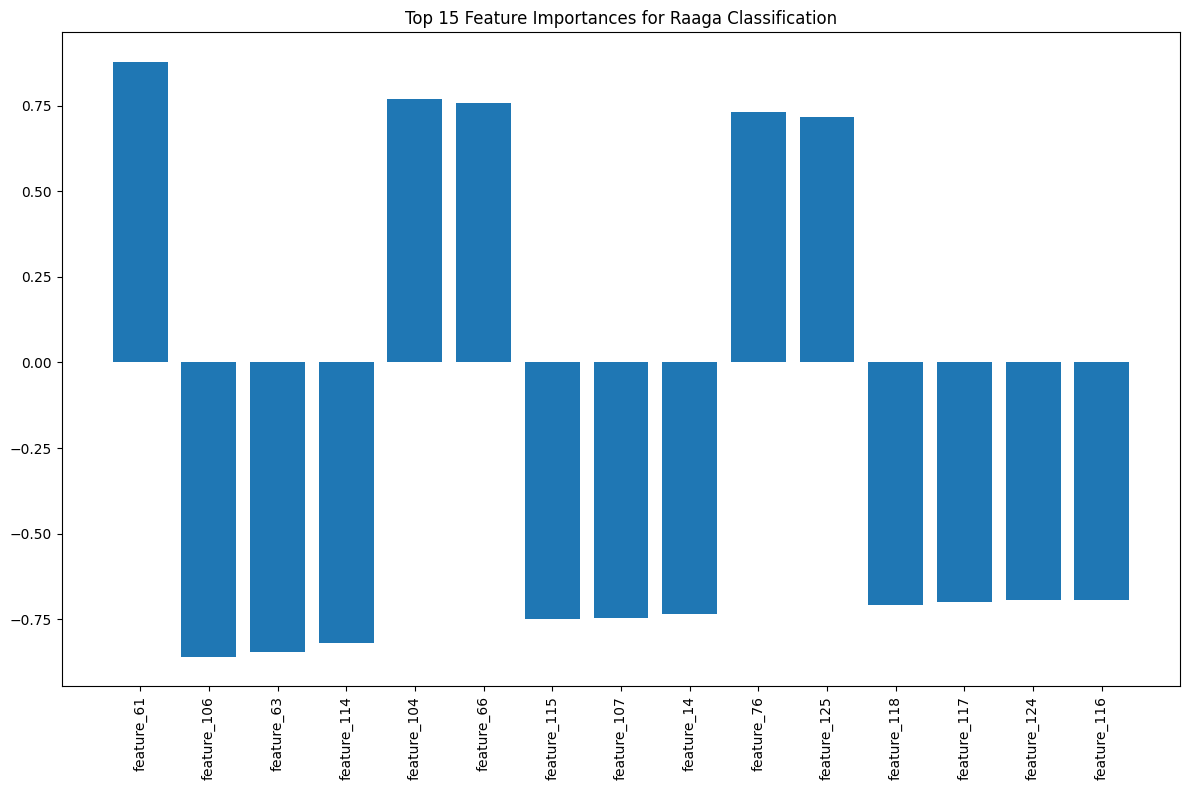

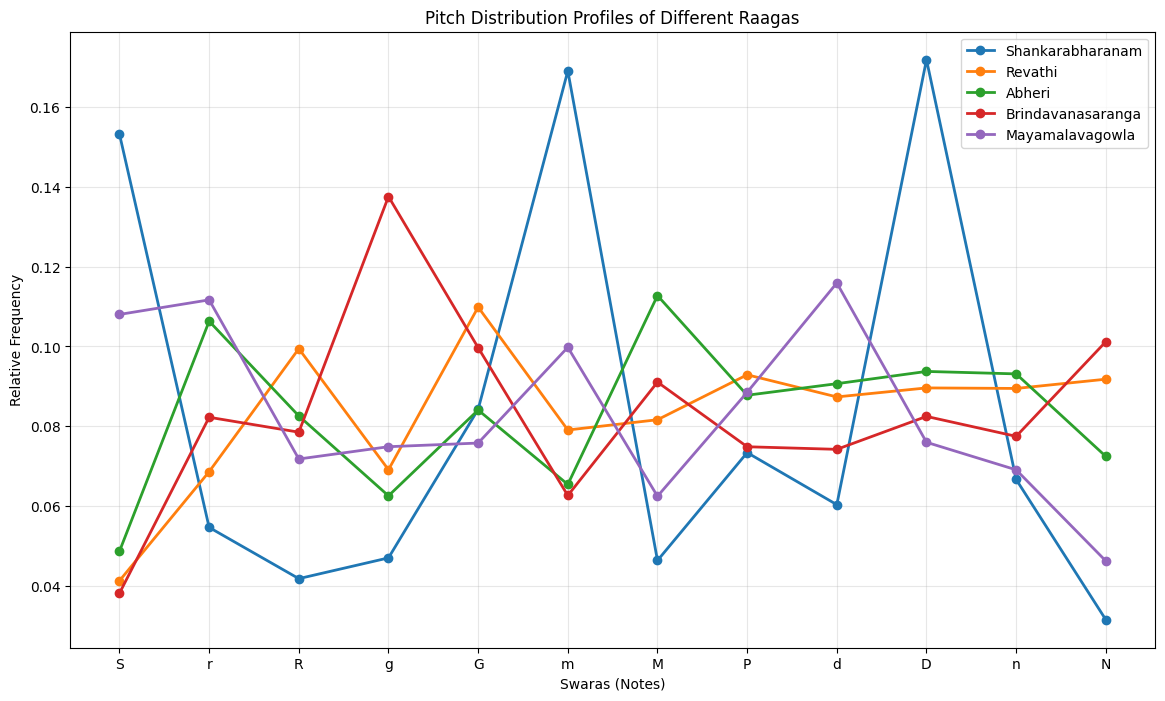


Building and training raaga classifier with T4 GPU acceleration...

Class Distribution:
Shankarabharanam: 158 samples
Brindavanasaranga: 138 samples
Mayamalavagowla: 120 samples
Abheri: 114 samples
Revathi: 108 samples
Compute dtype: float16
Variable dtype: float32
Epoch 1/12
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 318ms/step - accuracy: 0.3262 - loss: 1.6962 - val_accuracy: 0.8333 - val_loss: 0.8163 - learning_rate: 0.0010
Epoch 2/12
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7076 - loss: 0.8379 - val_accuracy: 0.9118 - val_loss: 0.4332 - learning_rate: 0.0010
Epoch 3/12
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8800 - loss: 0.4850 - val_accuracy: 0.9510 - val_loss: 0.2395 - learning_rate: 0.0010
Epoch 4/12
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9086 - loss: 0.2839 - val_accuracy: 0.9412 - val_loss: 0.1494 - learning_rate: 0.0010
Epoch 5/12
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9361 - loss: 0.2027 - val_accuracy: 0.9804 - val_loss: 0.0967 - lea

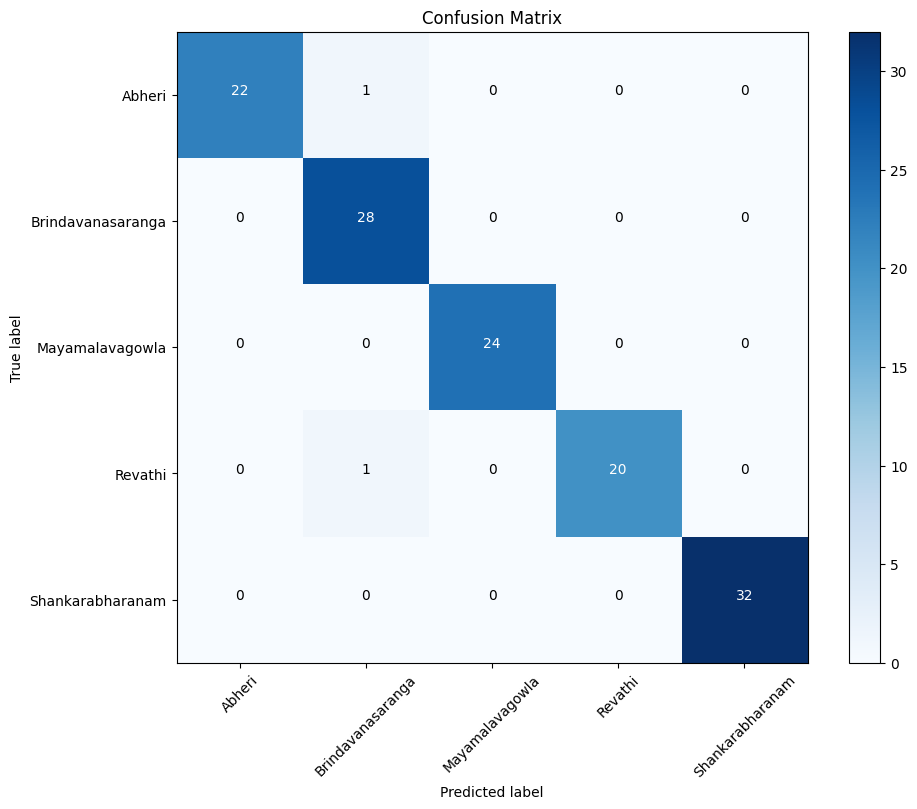

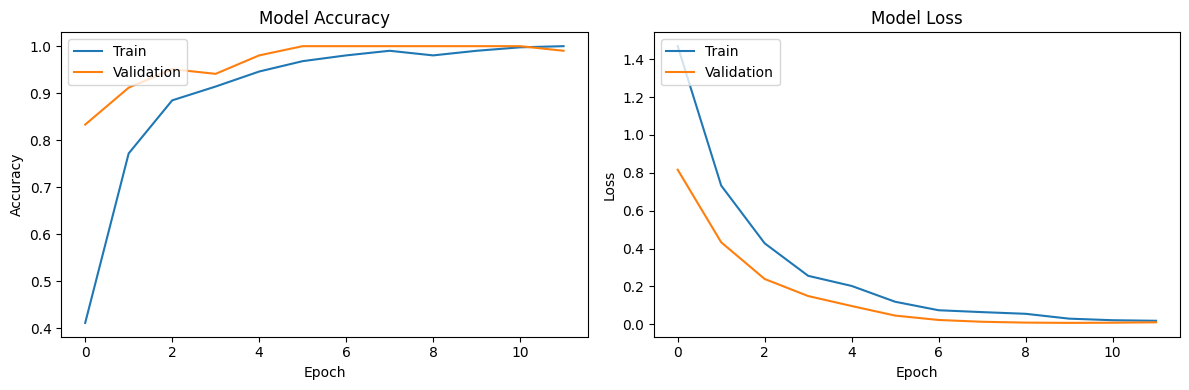

Model and preprocessing objects saved to disk.

Testing model with random samples from each raaga...

Testing with Shankarabharanam sample: MS Subbulakshmi- Sarojadala Netri- Shankarabharanam- Adi- Shyama Sastri [12Ayi_Bsmu0]_segment_117.mp3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
Actual Raaga: Shankarabharanam
Predicted Raaga: Shankarabharanam
Confidence: 1.0000 (100.00%)


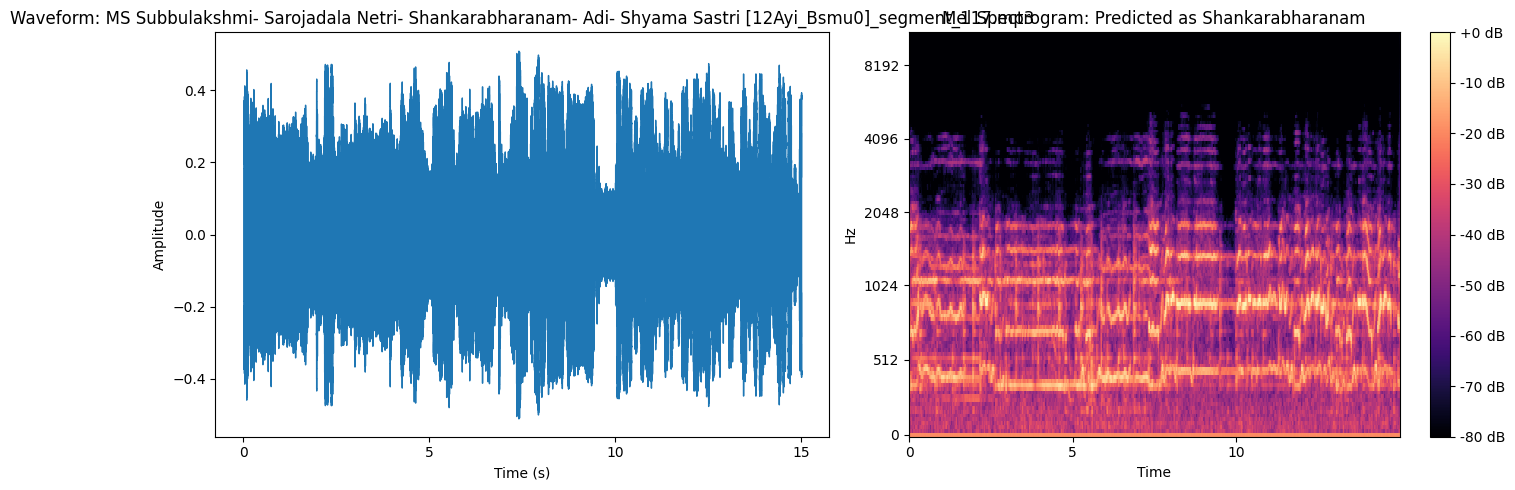


Testing with Revathi sample: Hariya Neneyiro [rB-XwI0nFR4]_segment_016.mp3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Actual Raaga: Revathi
Predicted Raaga: Revathi
Confidence: 0.9993 (99.93%)


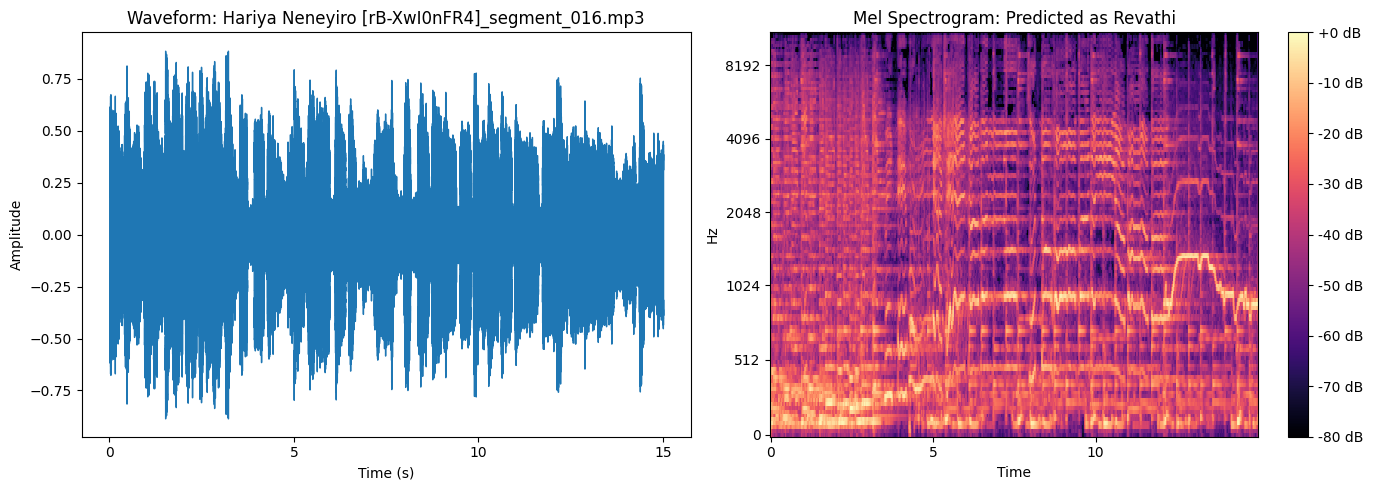


Testing with Abheri sample: Bhajare Re Manasa - Ragam Abheri - Mysore Vasudevachar Krithi [ebFAOkuXJB8]_segment_058.mp3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Actual Raaga: Abheri
Predicted Raaga: Abheri
Confidence: 0.9997 (99.97%)


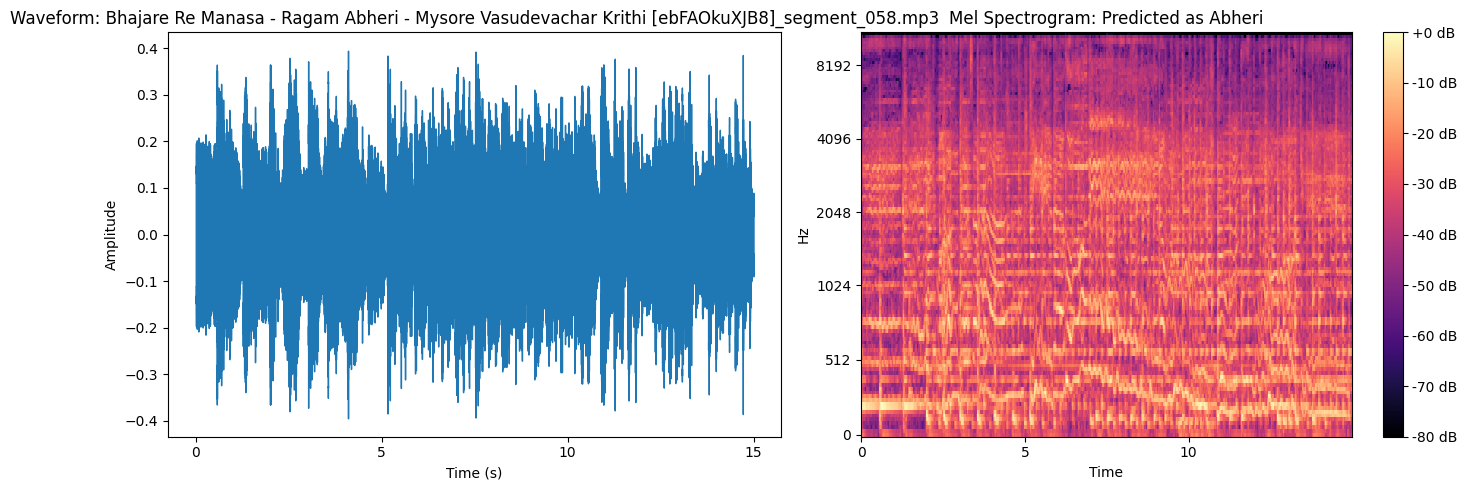


Testing with Brindavanasaranga sample: Brindavana Saranga _ Featuring @VishruthiGirish and @AnirudhSubramanian _ MadRasana Duet [rWyNis8keRc]_segment_011.mp3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Actual Raaga: Brindavanasaranga
Predicted Raaga: Brindavanasaranga
Confidence: 0.9988 (99.88%)


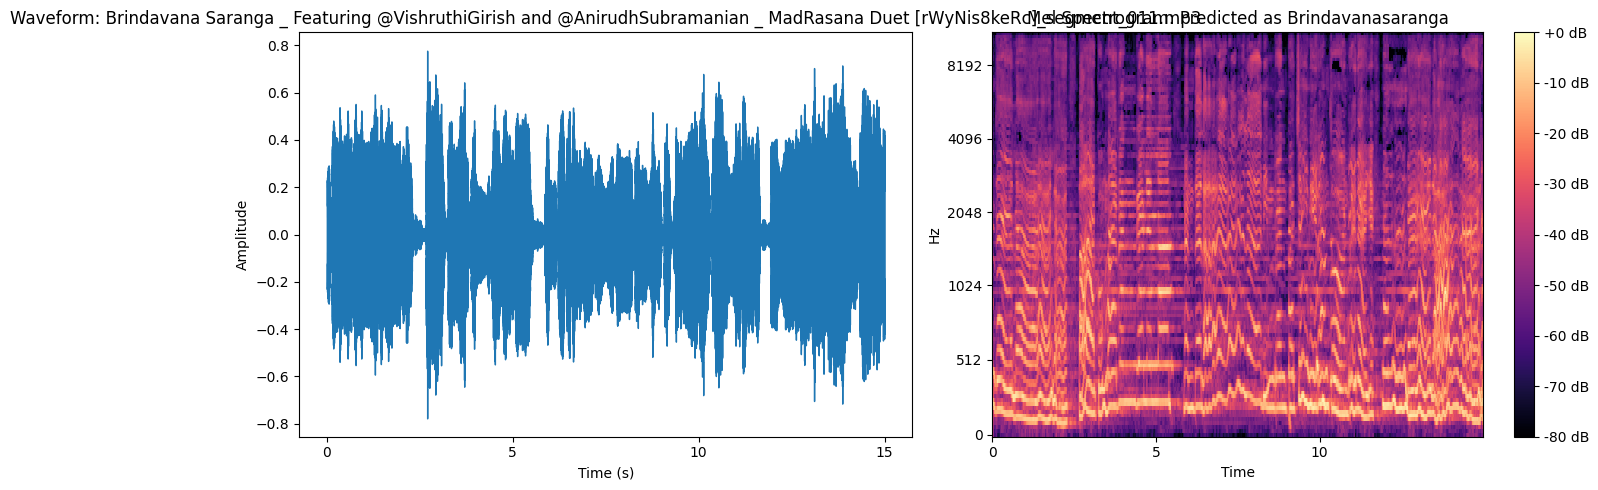


Testing with Mayamalavagowla sample: A vibrant keertanam on Lord Siva - _Adi Kondar_ by Rajadarshini Saravanan - Sridevi Nrithyalaya [gxK4MwLMyzk]_segment_005.mp3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Actual Raaga: Mayamalavagowla
Predicted Raaga: Mayamalavagowla
Confidence: 0.9995 (99.95%)


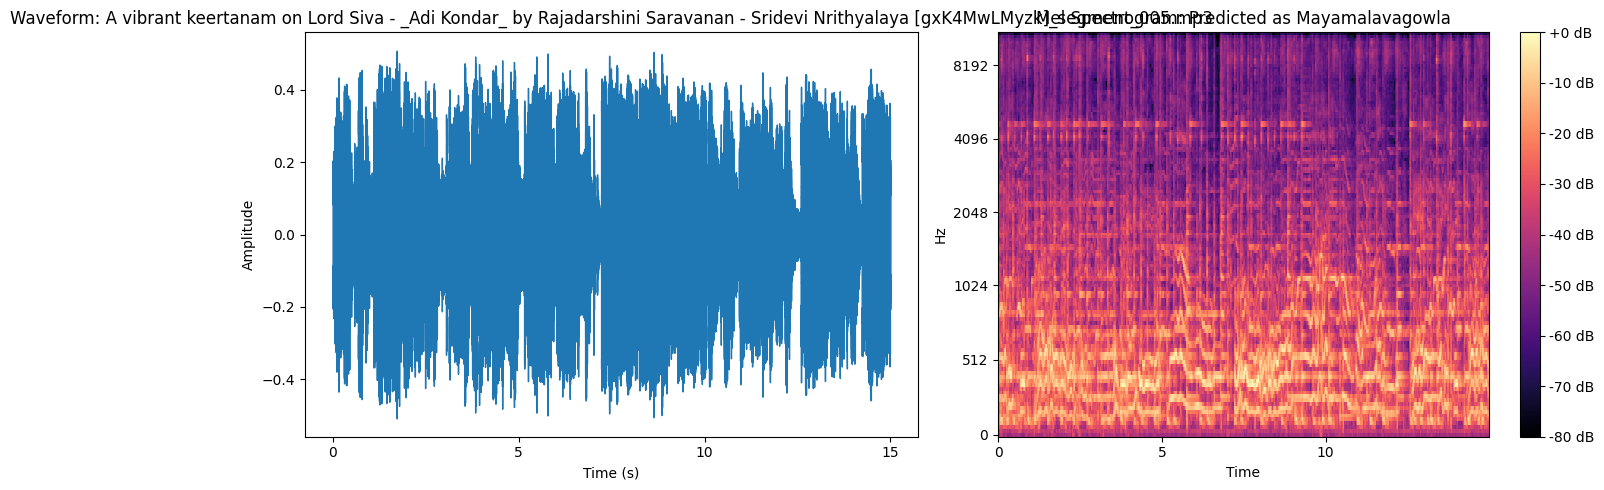


Classifying specific raaga clip: Bhajare Re Manasa - Ragam Abheri - Mysore Vasudevachar Krithi [ebFAOkuXJB8]_segment_002.mp3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted Raaga: Abheri
Confidence: 0.9999 (99.99%)


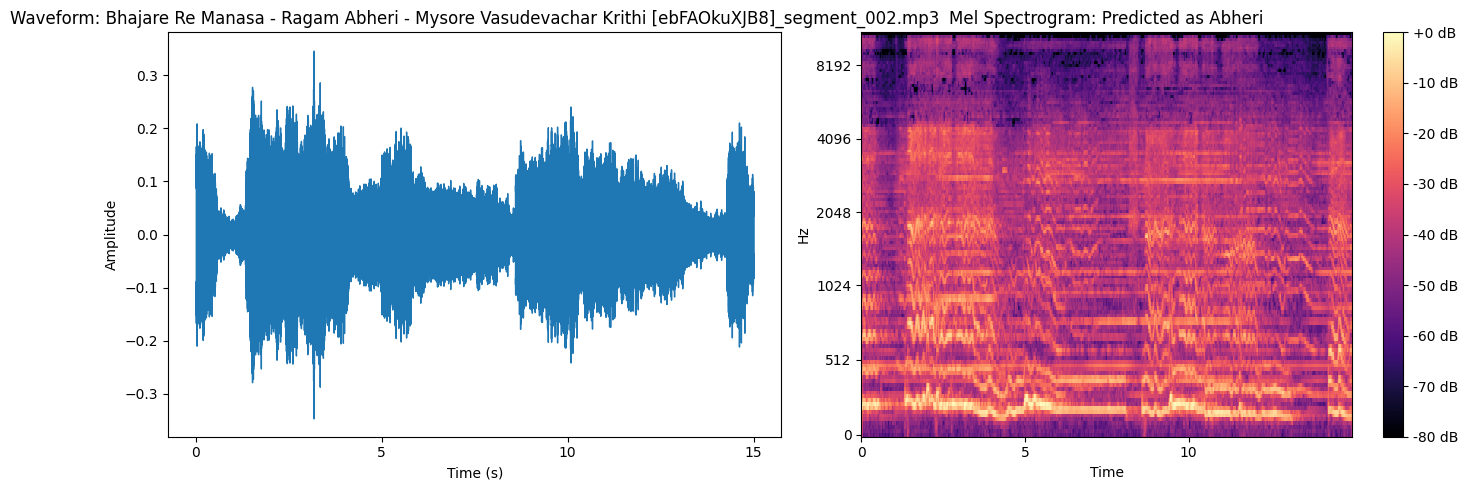


Verifying saved model...
Testing loaded model with: A vibrant keertanam on Lord Siva - _Adi Kondar_ by Rajadarshini Saravanan - Sridevi Nrithyalaya [gxK4MwLMyzk]_segment_005.mp3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
Predicted Raaga: Mayamalavagowla
Confidence: 0.9995 (99.95%)

Model and preprocessing objects saved to /content/drive/MyDrive/ML_RAAGA_Analysis/saved_model

Raaga analysis complete!


In [ ]:


if dataset is not None and len(dataset) > 0:
    print(f"Dataset created with {len(dataset)} samples across {len(dataset['raaga'].unique())} raagas")

    # Visualize features
    print("\nVisualizing raaga features...")
    visualize_raaga_features(dataset)

    # Build classifier
    print("\nBuilding and training raaga classifier with T4 GPU acceleration...")
    model, scaler, label_encoder = build_raaga_classifier(dataset)

    # Save model and preprocessing objects with proper extensions
    model.save('/content/raaga_model.keras')  # Fix: Added .keras extension
    import pickle
    with open('/content/raaga_scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)
    with open('/content/raaga_encoder.pkl', 'wb') as f:
        pickle.dump(label_encoder, f)
    print("Model and preprocessing objects saved to disk.")

    # Test the model with a random sample from each raaga
    print("\nTesting model with random samples from each raaga...")

    for raaga in raagas:
        raaga_path = os.path.join(DATASET_PATH, raaga)
        if not os.path.exists(raaga_path):
            print(f"Path not found: {raaga_path}")
            continue

        # Get a list of audio files for this raaga
        audio_files = [f for f in os.listdir(raaga_path) if f.endswith(('.mp3', '.wav'))]

        if not audio_files:
            print(f"No audio files found for {raaga}")
            continue

        # Select a random file
        import random
        random_file = random.choice(audio_files)
        random_clip = os.path.join(raaga_path, random_file)

        print(f"\nTesting with {raaga} sample: {os.path.basename(random_clip)}")
        predicted_raaga, confidence = classify_new_audio(random_clip, model, scaler, label_encoder)
        print(f"Actual Raaga: {raaga}")
        print(f"Predicted Raaga: {predicted_raaga}")
        print(f"Confidence: {confidence:.4f} ({confidence*100:.2f}%)")

        # Visualize the audio clip
        y, sr = librosa.load(random_clip, sr=22050)
        plt.figure(figsize=(14, 5))

        # Plot waveform
        plt.subplot(1, 2, 1)
        librosa.display.waveshow(y, sr=sr)
        plt.title(f'Waveform: {os.path.basename(random_clip)}')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')

        # Plot mel spectrogram
        plt.subplot(1, 2, 2)
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        S_dB = librosa.power_to_db(S, ref=np.max)
        librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Mel Spectrogram: Predicted as {predicted_raaga}')

        plt.tight_layout()
        plt.show()

    # Test with a specific file (optional)
    specific_clip = '/content/drive/MyDrive/ML_RAAGA_Analysis/Abheri/Bhajare Re Manasa - Ragam Abheri - Mysore Vasudevachar Krithi [ebFAOkuXJB8]_segment_002.mp3'

    if os.path.exists(specific_clip):
        print(f"\nClassifying specific raaga clip: {os.path.basename(specific_clip)}")
        predicted_raaga, confidence = classify_new_audio(specific_clip, model, scaler, label_encoder)
        print(f"Predicted Raaga: {predicted_raaga}")
        print(f"Confidence: {confidence:.4f} ({confidence*100:.2f}%)")

        # Visualize the audio clip
        y, sr = librosa.load(specific_clip, sr=22050)
        plt.figure(figsize=(14, 5))

        # Plot waveform
        plt.subplot(1, 2, 1)
        librosa.display.waveshow(y, sr=sr)
        plt.title(f'Waveform: {os.path.basename(specific_clip)}')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')

        # Plot mel spectrogram
        plt.subplot(1, 2, 2)
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        S_dB = librosa.power_to_db(S, ref=np.max)
        librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Mel Spectrogram: Predicted as {predicted_raaga}')

        plt.tight_layout()
        plt.show()

    # Verify that the saved model works by loading it and testing
    print("\nVerifying saved model...")
    loaded_model = tf.keras.models.load_model('/content/raaga_model.keras')

    with open('/content/raaga_scaler.pkl', 'rb') as f:
        loaded_scaler = pickle.load(f)

    with open('/content/raaga_encoder.pkl', 'rb') as f:
        loaded_encoder = pickle.load(f)

    # Test with a random file
    test_file = random_clip  # Using the last random clip

    print(f"Testing loaded model with: {os.path.basename(test_file)}")
    predicted_raaga, confidence = classify_new_audio(test_file, loaded_model, loaded_scaler, loaded_encoder)
    print(f"Predicted Raaga: {predicted_raaga}")
    print(f"Confidence: {confidence:.4f} ({confidence*100:.2f}%)")

    # Copy the saved model to Google Drive for future use
    import shutil
    save_dir = '/content/drive/MyDrive/ML_RAAGA_Analysis/saved_model'
    os.makedirs(save_dir, exist_ok=True)

    shutil.copy('/content/raaga_model.keras', f'{save_dir}/raaga_model.keras')
    shutil.copy('/content/raaga_scaler.pkl', f'{save_dir}/raaga_scaler.pkl')
    shutil.copy('/content/raaga_encoder.pkl', f'{save_dir}/raaga_encoder.pkl')

    print(f"\nModel and preprocessing objects saved to {save_dir}")

else:
    print("No valid audio files found. Please check your dataset path and silence threshold.")

print("\nRaaga analysis complete!")


In [ ]:
# --- This is the complete, CORRECTED SVM baseline code ---
# --- Run this in a new cell AFTER your 'dataset = create_dataset...' cell ---

print("--- Running SVM Baseline Experiment (Corrected) ---")

# Import all required libraries
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np # Required for np.number

# Check if the 'dataset' DataFrame exists (it should from your previous cells)
if 'dataset' in locals() and isinstance(dataset, pd.DataFrame):

    # 1. Re-create X (features) and y (labels) from your global 'dataset' DataFrame
    X = dataset.drop('raaga', axis=1)
    y = dataset['raaga']

    # 2. *** THE FIX IS HERE ***
    #    Find and drop any non-numeric columns (like the file paths)
    non_numeric_cols = X.select_dtypes(exclude=[np.number]).columns

    if not non_numeric_cols.empty:
        print(f"Found and automatically dropped non-numeric columns: {list(non_numeric_cols)}")
        X = X.drop(columns=non_numeric_cols)
    else:
        print("No non-numeric columns found in features. Proceeding.")

    # 3. Re-create the Train/Test Split
    #    Must use the SAME parameters as your DNN for a fair comparison
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    # 4. Create and fit the StandardScaler
    #    This is where the error happened before. It is now fixed.
    print("Scaling features...")
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)
    print("Features scaled successfully.")

    # 5. Train the SVM Classifier
    print("Training SVM baseline (kernel='rbf', C=10, gamma=0.1)...")
    svm_model = SVC(kernel='rbf', C=10, gamma=0.1) # Good starting parameters
    svm_model.fit(X_train_s, y_train) # Use the scaled training data

    # 6. Evaluate the SVM
    y_pred_svm = svm_model.predict(X_test_s) # Use the scaled test data
    svm_accuracy = accuracy_score(y_test, y_pred_svm)

    print("\n" + "="*35)
    print("   --- SVM BASELINE RESULT ---")
    print(f"   Test Accuracy: {svm_accuracy * 100:.2f}%")
    print("="*35)
    print("\n===> Please insert this 'Test Accuracy' value into the [..SVM ACCURACY..] placeholder in your .tex file <===")

else:
    print("Error: The 'dataset' DataFrame was not found.")
    print("Please make sure you have run the 'create_dataset' cell successfully before this one.")

--- Running SVM Baseline Experiment (Corrected) ---
Found and automatically dropped non-numeric columns: ['file_path']
Scaling features...
Features scaled successfully.
Training SVM baseline (kernel='rbf', C=10, gamma=0.1)...

   --- SVM BASELINE RESULT ---
   Test Accuracy: 57.03%

===> Please insert this 'Test Accuracy' value into the [..SVM ACCURACY..] placeholder in your .tex file <===
